# Nashville Police Service Calls Analysis

## Preparation

### Dependencies

In [281]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as LR

import utils

In [190]:
!python utils/preprocessing.py

testing


### Import data

* N.B. - The dataset is large (more than 6.5M records), so it is not available in this Github repo.

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; If you'd like the dataset, you may find it [here](https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Calls-for-Servic/kwnd-qrrm), on the nashville.gov website.

In [4]:
main_df = pd.read_csv('data/Metro_Nashville_Police_Department_Calls_for_Service.csv',
                      parse_dates=['Call Received'],
                     dtype={'Event Number': str,
                            'Complaint Number': float,
                            'Tencode': str,
                            'Tencode Description': str,
                            'Tencode Suffix': str,
                            'Tencode Suffix Description': str,
                            'Disposition Code': str,
                            'Disposition Description': str,
                            'Block': float,
                            'Street Name': str,
                            'Unit Dispatched': str,
                            'Shift': str,
                            'Sector': str,
                            'Zone': str,
                            'RPA': float,
                            'Latitude': float,
                            'Longitude': float,
                            'Mapped Location': str
                     })

In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570096 entries, 0 to 6570095
Data columns (total 19 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Event Number                object        
 1   Call Received               datetime64[ns]
 2   Complaint Number            float64       
 3   Tencode                     object        
 4   Tencode Description         object        
 5   Tencode Suffix              object        
 6   Tencode Suffix Description  object        
 7   Disposition Code            object        
 8   Disposition Description     object        
 9   Block                       float64       
 10  Street Name                 object        
 11  Unit Dispatched             object        
 12  Shift                       object        
 13  Sector                      object        
 14  Zone                        object        
 15  RPA                         float64       
 16  Latitude          

### Preprocessing

* Let's get a sample of the data to make it easier to work with.

In [7]:
samp_df = main_df.sample(frac=.01, random_state=22)

In [ ]:
cols = ['Event Number', 'Call Received', 'Complaint Number', 'Tencode',
       'Tencode Description', 'Tencode Suffix', 'Tencode Suffix Description',
       'Disposition Code', 'Disposition Description', 'Block', 'Street Name',
       'Unit Dispatched', 'Shift', 'Sector', 'Zone', 'RPA', 'Latitude',
       'Longitude', 'Mapped Location']

#### 'Event Number'

* It looks like all the event numbers begin with 'PD'; if this is the case, then I can strip those two characters and cast as an int, saving space

In [ ]:
pd_check = [event.startswith('PD') for event in samp_df['Event Number'].values]

In [ ]:
print(sum(pd_check))

In [8]:
def event_number_clean(num):
    return int(num[2:])

In [9]:
samp_df['Event Number'] = samp_df['Event Number'].apply(event_number_clean)

In [10]:
samp_df.iloc[[0]]

,Event Number,Call Received,Complaint Number,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location
5797724,201601214292,2016-12-01 16:51:05,NaN,88,INVESTIGATE 911 HANG-UP CALL,PW,NaN,5,GONE ON ARRIVAL,NaN,NaN,322B,B,S,327,8861.0,NaN,NaN,NaN


#### 'Call Received'

* This is a datetime column, so I'll parse as I read in the csv

In [ ]:
samp_df['Call Received'].head(20)

#### 'Complaint Number'

* I am not interested in the specific number, just whether or not an incident was generated, so I'll update this to a simple Boolean flag

In [ ]:
samp_df['Complaint Number'].isna().value_counts()

In [ ]:
type(samp_df['Complaint Number'][5797724])

In [11]:
def complaint_number_clean(num):
    if np.isnan(num):
        return 0
    else:
        return 1

In [13]:
samp_df['generated_incident_yn'] = samp_df['Complaint Number'].apply(complaint_number_clean)
samp_df.drop('Complaint Number', axis=1)

,Event Number,Call Received,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
5797724,201601214292,2016-12-01 16:51:05,88,INVESTIGATE 911 HANG-UP CALL,PW,NaN,5,GONE ON ARRIVAL,NaN,NaN,322B,B,S,327,8861.0,NaN,NaN,NaN,0
6541170,202100376271,2021-06-10 21:08:23,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,PV,NaN,5,GONE ON ARRIVAL,NaN,NaN,5P66,B,H,535,8937.0,NaN,NaN,NaN,0
827216,201600371223,2016-04-10 20:40:50,93,TRAFFIC VIOLATION,NaN,NaN,9T,NaN,NaN,BELL RD,332B,B,335,NaN,8721.0,36.045,-86.662,POINT (-86.662 36.045),0
503265,201900487756,2019-06-03 10:42:15,71,BURGLARY - NON-RESIDENCE,R,REPORT,1,M.P.D. REPORT COMPLED,NaN,NaN,811A,A,NaN,NaN,NaN,NaN,NaN,NaN,1
4525988,202000445523,2020-06-05 00:59:52,83,SHOTS FIRED,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,NaN,NaN,C,S,321,8445.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624901,201700282688,2017-03-20 02:56:17,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,5W,NaN,300.0,MAY DR,713C,C,NaN,NaN,NaN,NaN,NaN,NaN,0
4544265,201700096670,2017-01-27 13:07:50,40,SUSPICIOUS PERSON,P,PROGRESS,4,ASSISTED CITIZEN,NaN,NaN,831A,A,MT,825,7111.0,NaN,NaN,NaN,0
575371,201500412850,2015-04-20 12:59:47,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,A,ALARM,11,DISREGARD / SIGNAL 9,NaN,NaN,331A,A,S,337,8905.0,NaN,NaN,NaN,0
5811427,201700214083,2017-02-28 07:58:57,93,TRAFFIC VIOLATION,NaN,NaN,3T,NaN,NaN,NaN,715B,A,S,331,8767.0,NaN,NaN,NaN,0


In [14]:
# check the function
samp_df['generated_incident_yn'].value_counts()

0    60129
1     5572
Name: generated_incident_yn, dtype: int64

In [ ]:
# Markdown shortcut!
for col in cols:
    print(f"#### '{col}'")

#### 'Tencode'

* This column seems to be clean. It's high-cardinality, and the codes are numeric, so I'll have to be careful with them if I do any modeling.

In [15]:
samp_df['Tencode'].value_counts()

43      12710
96      11993
93      11775
15       3422
44       2926
45       2918
50       2729
87       2448
40       2223
70       1943
71       1888
3        1624
88       1375
46        795
49        692
57        679
83        572
95        394
53        337
92        333
54        287
75        261
65        256
16        230
63        215
42        164
64         88
61         56
59         55
35         55
52         51
62         45
58         35
14         33
94         22
73         21
51         12
1000       10
68         10
3000        4
77          4
66          4
8000        4
89          2
79          1
Name: Tencode, dtype: int64

#### 'Tencode Description'

* It looks like there are some blanks here.
* However, the desciptions match the appendix in the metadata document, so rather than clogging the dataframe with strings, I'll remove this column.

In [ ]:
samp_df['Tencode Description'].isna().value_counts()

In [ ]:
samp_df[samp_df['Tencode Description'].notna()].head(20)

In [16]:
samp_df = samp_df.drop('Tencode Description', axis=1)

#### 'Tencode Suffix'

* Like the tencode column, this is high-cardinality, though these are mostly strings instead of numeric values. For consistency, it looks like I should read the csv with the datatypes specified.

In [ ]:
type(samp_df['Tencode Suffix'][5797724])

In [17]:
samp_df['Tencode Suffix'].value_counts()

P     26379
A      3823
R      3130
PV     1144
TS      869
PM      856
PW      743
PJ      649
RT      614
TV      586
RV      346
RJ      177
RC      169
W       134
L        98
T        44
PD       30
H        28
F        20
B        12
RD        9
PR        8
FI        4
S         3
RG        1
Name: Tencode Suffix, dtype: int64

#### 'Tencode Suffix Description'

* This one is like the tencode description, a string which is unneeded. I'll drop the column.

In [18]:
samp_df = samp_df.drop('Tencode Suffix Description', axis=1)

#### 'Disposition Code'

* Interestingly, it would appear that tencode suffixes are sometimes appended to the disposition code instead of the tencode. That'll be fun to clean up!

* Here's my thinking:    
    * If the disposition code includes a letter which is not a valid option, and it is a valid option as a tencode suffix, and it is not already present in the tencode suffix, I'll append the letter to the tencode suffix and remove from the disposition code.
    * If the disposition code includes a letter which is not a valid option, and it is *not* a valid option as a tencode suffix, I'll remove the letter.
    * If the disposition code includes a letter which is a valid option, and it is *also* a valid option as a tencode suffix, I'll do the following:
        * For A:
            * disposition codes 1, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15 seem unlikely to result in arrest, so the A will be considered as a tencode and appended if not already present.
            * disposition codes 2, 3, 6, 12 seem like they could plausibly result in arrest, so the A will be left as part of the disposition code.
        * For C, O, and P:
            * if the letter is *not* included in the tencode suffix, I'll append it, while also leaving it as part of the disposition code.
            * if the letter is already included in the tencode suffix, I'll do nothing, leaving it in both places.

In [43]:
samp_df['Disposition Code'].isna().value_counts()

False    65427
True       274
Name: Disposition Code, dtype: int64

In [77]:
def disposition_code_clean(row):
    
    # The three variables calculated here must all be strings for the function to work.
    
    # First test for nan (the disposition code or tencode is a float if it is nan, otherwise it's a str).
    if isinstance(row['Disposition Code'], float):
        return row
    else:
        disp_code_letter = str(row['Disposition Code'])[-1:]
        disp_code_number = str(row['Disposition Code'])[:-1]

    if isinstance(row['Tencode Suffix'], float):
        tencode_suffix = ''
    else:
        tencode_suffix = str(row['Tencode Suffix'])
    
    if disp_code_letter.isnumeric():
        return row
    elif disp_code_letter not in ['A', 'C', 'O', 'P']:
        if disp_code_letter not in tencode_suffix:
            row['Tencode Suffix'] = tencode_suffix + disp_code_letter
            row['Disposition Code'] = disp_code_number
        else:
            row['Disposition Code'] = disp_code_number   
    else:
        if disp_code_letter == 'A':
            if disp_code_number in ['1', '4', '5', '7', '8', '9', '10', '11', '13', '14', '15']:
                if disp_code_letter not in tencode_suffix:
                    row['Tencode Suffix'] = tencode_suffix + disp_code_letter
                    row['Disposition Code'] = disp_code_number
                else:
                    row['Disposition Code'] = disp_code_number
            else:
                return row
        elif disp_code_letter in ['C', 'O', 'P']:
            if disp_code_letter not in tencode_suffix:
                row['Tencode Suffix'] = tencode_suffix + disp_code_letter
            else:
                return row
    
    # After all the above processing, if there is still nothing in the tencode suffix column, return it to nan
    if row['Tencode Suffix'] == '':
        row['Tencode Suffix'] = np.nan
    
    return row

In [ ]:
clean_dispo = ambig_df.apply(disposition_code_clean, axis=1)

In [ ]:
clean_dispo.shape

(1141, 18)

In [ ]:
clean_dispo

,Event Number,Call Received,Complaint Number,Tencode,Tencode Suffix,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
1891040,201500296004,2015-03-20 16:05:16,NaN,43,PJC,4C,NaN,200.0,GARNER AV,713B,B,M,715,1725.0,36.27,-86.708,POINT (-86.708 36.27),0
1055263,201801234079,2018-12-27 09:40:34,2.018107e+10,43,RC,1C,NaN,5100.0,HARDING PL,SAPR,A,NaN,323W,0.0,36.09,-86.688,POINT (-86.688 36.09),1
6352074,202100106242,2021-02-15 06:44:08,2.021009e+10,43,PMC,1C,NaN,NaN,NaN,213A,A,E,213,1329.0,NaN,NaN,NaN,1
1414889,201500808343,2015-07-30 07:25:08,2.015072e+10,43,RC,1C,NaN,NaN,NaN,525A,A,NaN,NaN,NaN,NaN,NaN,NaN,1
163595,202100656627,2021-10-17 14:26:56,NaN,3,C,4C,NaN,5100.0,HARDING PL,327B,A,NaN,323W,0.0,36.09,-86.688,POINT (-86.688 36.09),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4060628,201800348676,2018-04-05 20:16:43,NaN,71,A,10,NaN,NaN,NaN,510B1,B,H,513,9001.0,NaN,NaN,NaN,0
3951798,201500451445,2015-04-29 22:04:56,NaN,71,A,12A,NaN,NaN,NaN,815B,B,MT,811,5519.0,NaN,NaN,NaN,0
137748,202200057557,2022-01-31 12:30:48,NaN,70,A,12A,NaN,NaN,NaN,354B,A,S,335,8905.0,NaN,NaN,NaN,0
877772,202000274232,2020-04-04 03:59:56,NaN,70,A,6A,NaN,NaN,NaN,225C,C,E,225,1809.0,NaN,NaN,NaN,0


In [ ]:
ambig_df.reset_index(inplace=True)

In [ ]:
isinstance(ambig_df['Tencode Suffix'][1891040], float)

False

In [ ]:
ambig_df

,Event Number,Call Received,Complaint Number,Tencode,Tencode Suffix,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
1891040,201500296004,2015-03-20 16:05:16,NaN,43,PJ,4C,NaN,200.0,GARNER AV,713B,B,M,715,1725.0,36.27,-86.708,POINT (-86.708 36.27),0
1055263,201801234079,2018-12-27 09:40:34,2.018107e+10,43,R,1C,NaN,5100.0,HARDING PL,SAPR,A,NaN,323W,0.0,36.09,-86.688,POINT (-86.688 36.09),1
6352074,202100106242,2021-02-15 06:44:08,2.021009e+10,43,PM,1C,NaN,NaN,NaN,213A,A,E,213,1329.0,NaN,NaN,NaN,1
1414889,201500808343,2015-07-30 07:25:08,2.015072e+10,43,R,1C,NaN,NaN,NaN,525A,A,NaN,NaN,NaN,NaN,NaN,NaN,1
163595,202100656627,2021-10-17 14:26:56,NaN,3,NaN,4C,NaN,5100.0,HARDING PL,327B,A,NaN,323W,0.0,36.09,-86.688,POINT (-86.688 36.09),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4060628,201800348676,2018-04-05 20:16:43,NaN,71,A,10A,NaN,NaN,NaN,510B1,B,H,513,9001.0,NaN,NaN,NaN,0
3951798,201500451445,2015-04-29 22:04:56,NaN,71,A,12A,NaN,NaN,NaN,815B,B,MT,811,5519.0,NaN,NaN,NaN,0
137748,202200057557,2022-01-31 12:30:48,NaN,70,A,12A,NaN,NaN,NaN,354B,A,S,335,8905.0,NaN,NaN,NaN,0
877772,202000274232,2020-04-04 03:59:56,NaN,70,A,6A,NaN,NaN,NaN,225C,C,E,225,1809.0,NaN,NaN,NaN,0


In [ ]:
pd.set_option("display.max_rows", 100)

In [ ]:
samp_df['Disposition Code'].value_counts()

In [ ]:
pd.reset_option("display.max_rows")

In [ ]:
ambig_df = samp_df[samp_df['Disposition Code'].str.contains('A|C|O|P', case=False, regex=True, na=False)]

In [78]:
samp_df = samp_df.apply(disposition_code_clean, axis=1)

In [79]:
samp_df

,Event Number,Call Received,Complaint Number,Tencode,Tencode Suffix,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
5797724,201601214292,2016-12-01 16:51:05,NaN,88,PW,5,GONE ON ARRIVAL,NaN,NaN,322B,B,S,327,8861.0,NaN,NaN,NaN,0
6541170,202100376271,2021-06-10 21:08:23,NaN,43,PV,5,GONE ON ARRIVAL,NaN,NaN,5P66,B,H,535,8937.0,NaN,NaN,NaN,0
827216,201600371223,2016-04-10 20:40:50,NaN,93,T,9,NaN,NaN,BELL RD,332B,B,335,NaN,8721.0,36.045,-86.662,POINT (-86.662 36.045),0
503265,201900487756,2019-06-03 10:42:15,2.019042e+10,71,R,1,M.P.D. REPORT COMPLED,NaN,NaN,811A,A,NaN,NaN,NaN,NaN,NaN,NaN,1
4525988,202000445523,2020-06-05 00:59:52,NaN,83,P,11,DISREGARD / SIGNAL 9,NaN,NaN,NaN,C,S,321,8445.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624901,201700282688,2017-03-20 02:56:17,NaN,43,PW,5,NaN,300.0,MAY DR,713C,C,NaN,NaN,NaN,NaN,NaN,NaN,0
4544265,201700096670,2017-01-27 13:07:50,NaN,40,P,4,ASSISTED CITIZEN,NaN,NaN,831A,A,MT,825,7111.0,NaN,NaN,NaN,0
575371,201500412850,2015-04-20 12:59:47,NaN,43,A,11,DISREGARD / SIGNAL 9,NaN,NaN,331A,A,S,337,8905.0,NaN,NaN,NaN,0
5811427,201700214083,2017-02-28 07:58:57,NaN,93,T,3,NaN,NaN,NaN,715B,A,S,331,8767.0,NaN,NaN,NaN,0


#### 'Disposition Description'

* Like the other two descriptive columns, this one doesn't hold information that's not already present in the metadata pdf. I'll remove.

In [81]:
samp_df['Disposition Description'].value_counts()

LOCATION/BUILDING SECURE         9374
ASSISTED CITIZEN                 8991
DISREGARD / SIGNAL 9             7710
COMMUNITY POLICING               7038
ASSISTED OTHER UNIT              4862
M.P.D. REPORT COMPLED            4631
GONE ON ARRIVAL                  3459
SUBJECT WARNED                   2113
NO RESPONSE                      1322
CITATION - TRAFFIC                644
FALSE CALL                        611
ARREST, CUSTODIAL OR CITATION     228
ASSISTANCE REFUSED                206
ADVISED IN CIVIL CASE             144
ADVISORY / NOTICE FORM GIVEN       47
Name: Disposition Description, dtype: int64

In [82]:
samp_df = samp_df.drop('Disposition Description', axis=1)

In [83]:
samp_df.shape

(65701, 17)

#### 'Block'

* It appears that most of the 'Block' column is left blank, but there may be interesting location information there, so I'll keep for now.

In [85]:
samp_df['Block'].isna().value_counts()

True     50710
False    14991
Name: Block, dtype: int64

In [86]:
samp_df['Block'].value_counts()

400.0      962
300.0      906
100.0      794
200.0      705
600.0      536
          ... 
8400.0       2
8900.0       2
15500.0      1
8700.0       1
12900.0      1
Name: Block, Length: 96, dtype: int64

#### 'Street Name'

* As with the block, many records don't include the street name, but enough do, and the information could be valuable enough, that I'll keep the column for now.

In [89]:
samp_df['Street Name'].isna().value_counts()

True     47987
False    17714
Name: Street Name, dtype: int64

In [87]:
samp_df['Street Name'].value_counts()

OLD HICKORY BLVD      964
CHARLOTTE PKE         709
MURFREESBORO PKE      559
BELL RD               555
LEBANON PKE           534
                     ... 
GASSER DR               1
SELLS DR                1
MM 32 4 I24 W           1
CRESCENT VALLEY LN      1
APEX ST                 1
Name: Street Name, Length: 1456, dtype: int64

#### 'Unit Dispatched'

* Since I know nothing about the units (for example, what the codes mean, or which areas they cover), I'll remove this column.

In [90]:
samp_df['Unit Dispatched'].value_counts()

125C     351
121C     269
423C     268
815C     264
421C     260
        ... 
35S45      1
541C9      1
620B9      1
4D54       1
1E17       1
Name: Unit Dispatched, Length: 2364, dtype: int64

In [91]:
samp_df = samp_df.drop('Unit Dispatched', axis=1)

#### 'Shift'

* This feature sorts the times of the call into three groups: A (daytime), B (evening), and C (night). Even though this information could be gleaned from the 'Call Received' feature, it may be a time-saver to keep this simple summary column. I'll update it to a pandas categorical to save some space.

In [93]:
samp_df['Call Received'].isna().value_counts()

False    65701
Name: Call Received, dtype: int64

In [92]:
samp_df['Shift'].value_counts()

A    25178
B    24712
C    15811
Name: Shift, dtype: int64

In [94]:
samp_df['Shift'] = samp_df['Shift'].astype('category')

#### 'Sector' and 'Zone'

* This should be one of only a handful of letters: C, E, H, M, MT, N, S, W. My hypothesis is that there are some zone codes in this column, and clearly there are some typos as well. Let's clean it at the same time as the zone!

* The zone must be a 3-digit numeral beginning with 1-9.

* The first digit of the zone code applies to the sector as follows:
    {'1': 'W',
    '2': 'E',
    '3': 'S',
    '4': 'C',
    '5': 'H',
    '6': 'N',
    '7': 'M',
    '8': 'MH'
    }

In [157]:
def sector_and_zone_clean(row):
    
    zone_to_sect_dct = {'1': 'W',
                        '2': 'E',
                        '3': 'S',
                        '4': 'C',
                        '5': 'H',
                        '6': 'N',
                        '7': 'M',
                        '8': 'MH'
                       }
    
    # this dict won't catch all typos (with more time, I'd throw some regex at it haha!), but it will help
    typo_dct = {'TE': 'E',
                'PCW': 'W',
                'ECC': 'C',
                'CENTRA': 'C',
                'CW': 'W',
                'HERMIT': 'H',
                'SOUTH': 'S',
                'MADISO': 'M',
                'EAST': 'E',
                'WEST': 'W',
                'NORTH': 'N',
                'MIDTOW': 'MH'
               }
    
    
    # First test for nan (the zone or sector is a float if it is nan, otherwise it's a str).
    if isinstance(row['Sector'], float) and isinstance(row['Zone'], float):
        # both sector and zone are nans
        return row
    elif isinstance(row['Sector'], float):
        # sector is a nan
        sector_letter = ''
        if len(row['Zone']) > 3:
            # zone may include the sector letter(s)
            if row['Zone'][-2].isnumeric() and row['Zone'][-1].isalpha():
                # only the final char is alphabetic
                if row['Zone'][-1] in zone_to_sect_dct.values():
                    sector_letter = row['Zone'][-1]
                    zone_number = ''
                else:
                    zone_number = row['Zone'][:3]
            elif row['Zone'][-2].isalpha():
                # the final two chars are alphabetic
                if row['Zone'][-2:].upper() == 'MH':
                    sector_letter = 'MH'
                
                if row['Zone'][:3].isnumeric():
                    zone_number = row['Zone'][:3]
                else:
                    zone_number = ''
            else:
                # otherwise we assume the zone includes (an) extra digit(s) at the end, and we truncate
                zone_number = row['Zone'][:3]
        elif len(row['Zone']) < 3:
            zone_number = ''
        else:
            # zone is 3 characters, but one of them may be a letter, most likely the final char
            if row['Zone'].isnumeric():
                # zone is all numerals
                zone_number = row['Zone']
            else:
                # zone includes either 1, 2, or 3 letters, in which case we do not have a valid zone number
                for i, char in enumerate(row['Zone'].upper()):
                    if i+1 < len(row['Zone']) and char in zone_to_sect_dct.values():
                        if char == 'M' and row['Zone'][i+1] == 'H':
                            # check if two successive chars are 'MH'
                            sector_letter = 'MH'
                        else:
                            sector_letter = char        
                    else:
                        if char in zone_to_sect_dct.values():
                            # if the final character is a sector code
                            sector_letter = char
            zone_number = ''
        # at this point, the variable zone_number holds a str which is either a 3-digit numeral or empty
        # and the variable sector_letter is likely an empty str (because it was a null) or possibly had a value imputed from the zone
    elif isinstance(row['Zone'], float):
        # zone is a nan
        zone_number = ''
        if row['Sector'].isnumeric():
            if len(row['Sector']) == 3:
                # this would mean the zone was inadvertently placed into the sector column
                zone_number += row['Sector']
                sector_letter = ''
                # otherwise the sector is a number with something other than 3 digits, so needs to be discarded; zone_number is already an empty str
        elif row['Sector'] in zone_to_sect_dct.values():
            # the sector code is a proper code
            sector_letter = row['Sector']
        elif row['Sector'] not in zone_to_sect_dct.values():
            # the code is alphabetic but not a proper sector code
            if row['Sector'].upper() in typo_dct.keys():
                sector_letter = typo_dct[row['Sector'].upper()]
            else:
                sector_letter = ''
        else:
            # in all other cases, since I don't have additional information, I will simply remove the sector code
            sector_letter = ''
    else:
        # both codes are strings
        if row['Sector'].isnumeric():
            if len(row['Sector']) == 3:
                # this would mean the zone was inadvertently placed into the sector column
                zone_number = row['Sector']
                sector_letter = ''
            else:
                # otherwise the sector is a number with something other than 3 digits, so needs to be discarded
                sector_letter = ''
                if len(row['Zone']) > 3:
                    zone_number = row['Zone'][:3]
                elif len(row['Zone']) < 3:
                    zone_number = ''
                else:
                    zone_number = row['Zone']
        elif row['Sector'] in zone_to_sect_dct.values():
            # the sector code is a proper code
            sector_letter = row['Sector']
            if len(row['Zone']) > 3:
                zone_number = row['Zone'][:3]
            elif len(row['Zone']) < 3:
                zone_number = ''
            else:
                zone_number = row['Zone']
        elif row['Sector'] not in zone_to_sect_dct.values():
            # the code is alphabetic but not a proper sector code
            if row['Sector'].upper() in typo_dct.keys():
                sector_letter = typo_dct[row['Sector'].upper()]
                if len(row['Zone']) > 3:
                    zone_number = row['Zone'][:3]
                elif len(row['Zone']) < 3:
                    zone_number = ''
                else:
                    zone_number = row['Zone']
            else:
                sector_letter = ''
                if len(row['Zone']) > 3:
                    zone_number = row['Zone'][:3]
                elif len(row['Zone']) < 3:
                    zone_number = ''
                else:
                    zone_number = row['Zone']
        else:
            # in all other cases, since I don't have additional information, I will simply remove the sector code
            sector_letter = ''
            if len(row['Zone']) > 3:
                zone_number = row['Zone'][:3]
            elif len(row['Zone']) < 3:
                zone_number = ''
            else:
                zone_number = row['Zone']
            

    # At this point, both sector_letter and zone_number should hold either empty str or useful information.
    # Now we can take the first digit of proper zone_numbers to determine the sector_letter.
    
    if sector_letter == '':
        if zone_number != '':
            # the sector is blank, but the zone is not
            try:
                sector_letter = zone_to_sect_dct[zone_number[0]]
                # the sector can be determined by the first char in the zone
            except:
                # if the first char in the zone is '9', this block will run
                sector_letter = np.nan
                zone_number = np.nan
            else:
                # if the zone number is a proper value, the except block will not run and this will
                zone_number = int(zone_number)
        else:
            # sector and zone are both blank
            sector_letter = np.nan
            zone_number = np.nan
    else:
        # sector is not blank
        if zone_number == '':
            # zone is blank
            zone_number = np.nan
        else:
            # otherwise neither sector nor zone is blank, in which case the variable values remain (with zone turned into an int for storage)
            zone_number = int(zone_number)
           
    # After all the above processing, we insert the two values into the dataframe
    row['Zone'] = zone_number
    row['Sector'] = sector_letter
    
    return row

In [139]:
test = samp_df.loc[5797724:827216]
# Includes 6541170
test

,Event Number,Call Received,Complaint Number,Tencode,Tencode Suffix,Disposition Code,Block,Street Name,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
5797724,201601214292,2016-12-01 16:51:05,NaN,88,PW,5,NaN,NaN,B,S,327,8861.0,NaN,NaN,NaN,0
6541170,202100376271,2021-06-10 21:08:23,NaN,43,PV,5,NaN,NaN,B,H,535,8937.0,NaN,NaN,NaN,0
827216,201600371223,2016-04-10 20:40:50,NaN,93,T,9,NaN,BELL RD,B,335,NaN,8721.0,36.045,-86.662,POINT (-86.662 36.045),0


In [150]:
test_sect = test.apply(sector_and_zone_clean, axis=1)

In [151]:
test_sect

,Event Number,Call Received,Complaint Number,Tencode,Tencode Suffix,Disposition Code,Block,Street Name,Shift,Sector,Zone,RPA,Latitude,Longitude,Mapped Location,generated_incident_yn
5797724,201601214292,2016-12-01 16:51:05,NaN,88,PW,5,NaN,NaN,B,S,327,8861.0,NaN,NaN,NaN,0
6541170,202100376271,2021-06-10 21:08:23,NaN,43,PV,5,NaN,NaN,B,H,535,8937.0,NaN,NaN,NaN,0
827216,201600371223,2016-04-10 20:40:50,NaN,93,T,9,NaN,BELL RD,B,S,335,8721.0,36.045,-86.662,POINT (-86.662 36.045),0


In [113]:
type(test['Sector'][827216])

str

In [114]:
samp_df['Sector'].isna().value_counts()

False    51135
True     14566
Name: Sector, dtype: int64

In [158]:
%%time
samp_df = samp_df.apply(sector_and_zone_clean, axis=1)

Wall time: 8.57 s


In [159]:
samp_df['Sector'].value_counts()

S     8596
W     8529
MH    7509
E     7468
C     7039
H     6879
N     5498
M     5072
Name: Sector, dtype: int64

In [131]:
zone_errors = samp_df[samp_df['Zone'].str.len() > 3]

In [133]:
zone_errors['last_char'] = zone_errors['Zone'].apply(lambda x: x[-1])

<ipython-input-133-b92dd7fb47ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_errors['last_char'] = zone_errors['Zone'].apply(lambda x: x[-1])


In [135]:
zone_errors['last_char'].value_counts()

N    1225
Z    1165
Y    1061
K    1043
W     887
X     870
V     785
T     291
U     244
P     115
S     101
Q      66
I      63
J      62
M      16
R      11
H       9
G       5
L       3
Name: last_char, dtype: int64

In [160]:
samp_df['Zone'].value_counts()

421.0    1443
425.0    1372
813.0    1318
315.0    1170
213.0    1143
         ... 
251.0       1
202.0       1
226.0       1
274.0       1
516.0       1
Name: Zone, Length: 132, dtype: int64

In [115]:
samp_df['Zone'].isna().value_counts()

False    57382
True      8319
Name: Zone, dtype: int64

#### 'RPA'

* Since I don't have additional information about these reporting areas, I'll remove this feature.

In [161]:
samp_df['RPA'].value_counts()

0.0        5731
8651.0      357
4093.0      331
4811.0      303
8861.0      300
           ... 
1890.0        1
15960.0       1
42021.0       1
3319.0        1
52025.0       1
Name: RPA, Length: 1890, dtype: int64

In [162]:
samp_df['RPA'].isna().value_counts()

False    52424
True     13277
Name: RPA, dtype: int64

In [163]:
samp_df = samp_df.drop('RPA', axis=1)

#### 'Latitude' and 'Longitude'

* Not a lot of calls have lat-lon coords, but they could be really useful when present, so I'll keep them for now!

In [164]:
samp_df['Latitude'].value_counts()

36.206    205
36.151    187
36.081    145
36.090    141
36.129    137
         ... 
36.119      1
36.361      1
36.353      1
36.351      1
36.112      1
Name: Latitude, Length: 319, dtype: int64

In [165]:
samp_df['Latitude'].isna().value_counts()

True     57078
False     8623
Name: Latitude, dtype: int64

In [166]:
samp_df['Longitude'].value_counts()

-86.779    164
-86.688    138
-86.778    125
-86.777    125
-86.822    118
          ... 
-86.983      1
-86.548      1
-86.894      1
-86.581      1
-86.884      1
Name: Longitude, Length: 368, dtype: int64

In [167]:
samp_df['Latitude'].isna().value_counts()

True     57078
False     8623
Name: Latitude, dtype: int64

#### 'Mapped Location'

* This column is a concatenation of lat and lon; since it's duplicate information, I'll remove it for speed (if I map later, I'll use a slice with just the non-nulls)

In [169]:
samp_df['Mapped Location'].isna().value_counts()

True     57078
False     8623
Name: Mapped Location, dtype: int64

In [170]:
samp_df = samp_df.drop('Mapped Location', axis=1)

## EDA

In [193]:
df = pd.read_feather('data/cleaned_data.feather')

* two goals:
    1. offer hope to people in Nashville
    2. increase retention and productivity of Ramsey Solutions team members


* tactics:
    1. partner with local churches (FPU) and high schools (Foundations) to give people access to curricula (assumption: financial wisdom is a pathway to improved social outcomes
        * focus on organizations in zones/precincts with high average call rates (calculated by standard time deltas), particularly for serious crime, or increasing call rates
    2. offer information to team members relocating to Nashville regarding safer areas to settle/purchase homes/raise children
        * focus on zones/precincts with low or decreasing call rates

In [200]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [201]:
df.describe()

,index,Event Number,Complaint Number,Block,Latitude,Longitude,generated_incident_yn
count,6570096.000,6570096.000,571275.000,1491804.000,853926.000,853926.000,6570096.000
mean,3285047.500,201769869394.758,20182269122.262,2338.459,35.963,-86.283,0.087
std,1896623.491,202181187.849,21228999.146,2245.265,2.626,6.300,0.282
min,0.000,201500000002.000,20150000018.000,0.000,0.000,-87.040,0.000
25%,1642523.750,201600603593.750,20160968774.500,500.000,36.087,-86.811,0.000
50%,3285047.500,201701289334.500,20180700866.000,1500.000,36.151,-86.728,0.000
75%,4927571.250,201900820889.250,20200426447.500,3800.000,36.203,-86.675,0.000
max,6570095.000,202200381099.000,20220307646.000,15500.000,36.402,0.000,1.000


In [204]:
cols = [col for col in df.columns]

In [205]:
cols

['index',
 'Event Number',
 'Call Received',
 'Complaint Number',
 'Tencode',
 'Tencode Suffix',
 'Disposition Code',
 'Block',
 'Street Name',
 'Shift',
 'Sector',
 'Zone',
 'Latitude',
 'Longitude',
 'generated_incident_yn']

In [258]:
df.tail(20)

,Event Number,Tencode,Tencode Suffix,Disposition Code,Block,Street Name,Shift,Sector,Zone,Latitude,Longitude,generated_incident_yn,year,month,day
6570076,202200381045,83,P,6,NaN,None,C,S,315,NaN,NaN,0,2022,6,22
6570077,202200381046,54,P,6,NaN,None,C,S,315,NaN,NaN,0,2022,6,22
6570078,202200381047,71,A,6,NaN,None,C,MH,811,NaN,NaN,0,2022,6,22
6570079,202200381048,49,P,11,NaN,None,C,C,421,NaN,NaN,0,2022,6,22
6570080,202200381049,43,PJ,4,100.000,UNIVERSITY CT,C,C,422,36.151,-86.765,0,2022,6,22
6570081,202200381052,43,P,11,NaN,None,C,W,None,NaN,NaN,0,2022,6,22
6570082,202200381053,43,P,4,NaN,None,C,M,715,NaN,NaN,0,2022,6,22
6570083,202200381054,50,TV,1,NaN,None,C,E,223,NaN,NaN,0,2022,6,22
6570084,202200381055,43,P,15,NaN,None,C,E,225,NaN,NaN,0,2022,6,22
6570085,202200381058,83,P,6,NaN,None,C,N,621,NaN,NaN,0,2022,6,22


In [207]:
df = df.sort_values(by=['Call Received', 'Event Number'])

In [209]:
df = df.reset_index(drop=True)

In [213]:
df = df.drop('index', axis=1)

In [220]:
test_df = df.loc[:10000,:]

In [239]:
test_df.loc[0, 'Call Received'].year

2015

* It looks like I have a little more preprocessing to do, since I am not sure if pandas can groupby an element of a datetime, and it's faster to just split out that column

In [240]:
def split_datetime(df):
    df['year'] = df.apply(lambda x: x['Call Received'].year, axis=1)
    df['month'] = df.apply(lambda x: x['Call Received'].month, axis=1)
    df['day'] = df.apply(lambda x: x['Call Received'].day, axis=1)
    
    df = df.drop('Call Received', axis=1)
    
    return df

In [241]:
df = split_datetime(df)

In [243]:
# tiny error in preprocessing script, so I need to drop the 'Complaint Number' column
df = df.drop('Complaint Number', axis=1)

### Counts

In [304]:
gb_year = df[['year', 'month', 'day']].groupby(by='year')
gb_month = df[['year', 'month', 'day']].groupby(by=['year', 'month'])
gb_day = df[['year', 'month', 'day']].groupby(by=['year', 'month', 'day'])

In [257]:
len(gb_year.get_group(2015))

1139672

In [310]:
len(gb_month.get_group((2015, 3)))

98988

In [289]:
last_date = datetime(2022, 6, 22).timetuple().tm_yday
projected_2022 = len(gb_year.get_group(2022)) / (last_date / 365)

In [316]:
x = np.array(range(2015, 2022)).reshape(-1, 1)
y = [len(gb_year.get_group(year)) for year in range(2015, 2022)]

reg = LR()
reg.fit(x, y)
preds = reg.predict(np.array(range(2015, 2024)).reshape(-1, 1))

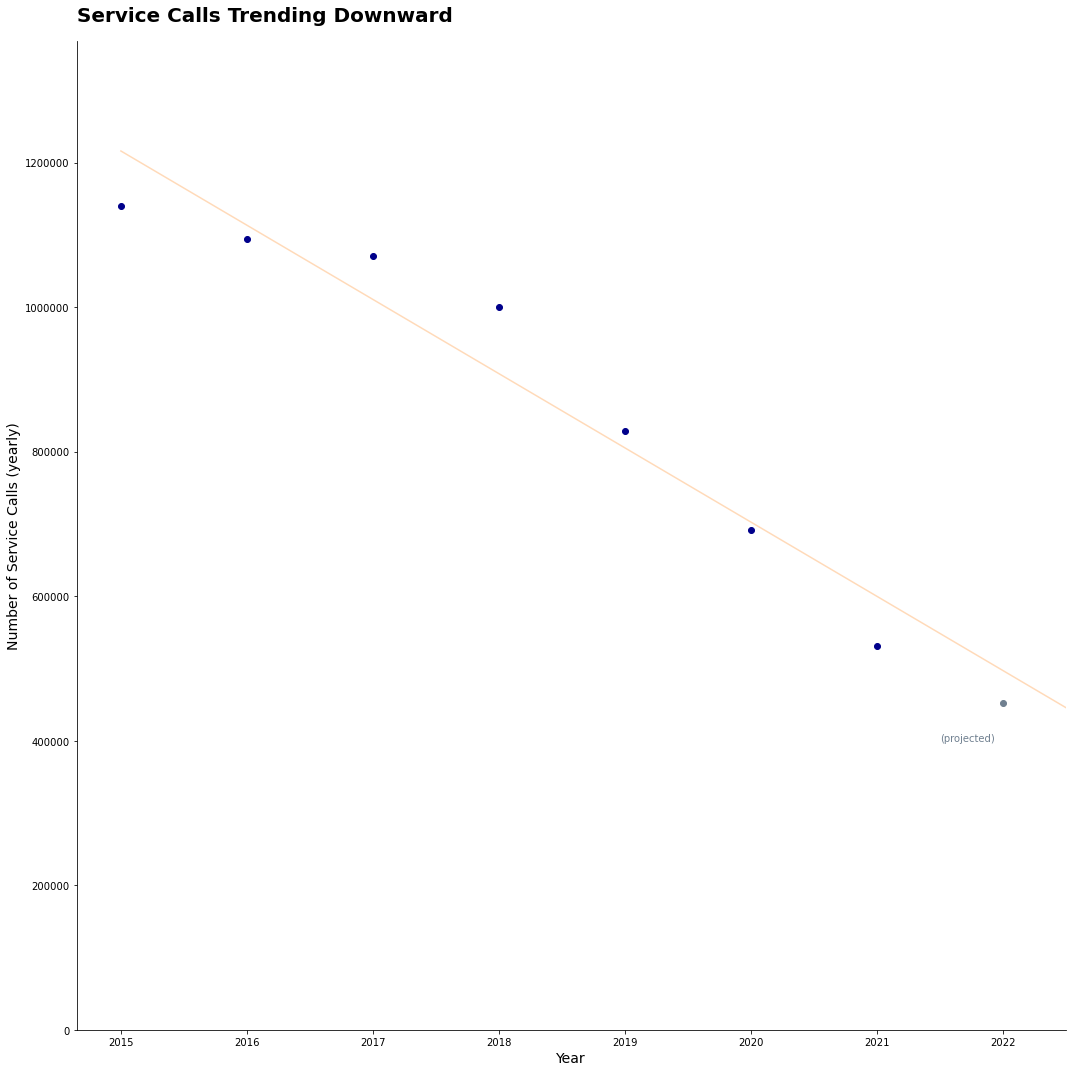

In [345]:
# plot the large-scale change in police activity

x = np.array(range(2015, 2022)).reshape(-1, 1)
y = [len(gb_year.get_group(year)) for year in range(2015, 2022)]

# calculate a line of best fit
reg = LR()
reg.fit(x, y)
preds = reg.predict(np.array(range(2015, 2024)).reshape(-1, 1))
    
# create the fig and ax
fig, ax = plt.subplots(figsize=(15, 15))

# scatterplot
ax.scatter(x, y, c='darkblue')
ax.scatter(2022, projected_2022, c='slategrey')
ax.annotate('(projected)', (2022, projected_2022), xytext=(2021.5, 400000), c='slategrey')
ax.ticklabel_format(style='plain')
ax.set_title('Service Calls Trending Downward',
             loc='left',
             pad=20,
             fontdict={
                 'fontsize': 20,
                 'fontweight': 'bold'
             }
            )
ax.set_ylim(bottom=0, top=max(y)*1.2)
ax.set_ylabel('Number of Service Calls (yearly)', fontsize=14)
ax.set_xlim(right=2022.5)
ax.set_xlabel('Year', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(np.array(range(2015, 2024)), preds, c='peachpuff')

plt.tight_layout()
plt.savefig('viz/yearly_calls.png')

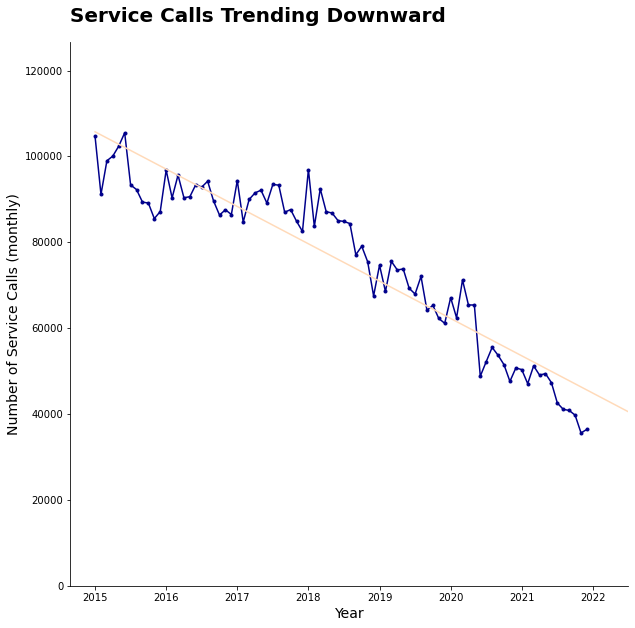

In [330]:
# create the fig and ax
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(2015, 2022, 7*12, endpoint=False).reshape(-1, 1)
y = []
for year in range(2015, 2022):
    for month in range(1, 13):
        y.append(len(gb_month.get_group((year, month))))

        
# calculate a line of best fit
reg = LR()
reg.fit(x, y)
preds = reg.predict(np.array(range(2015, 2024)).reshape(-1, 1))

# plot
ax.plot(x, y, marker='.', c='darkblue')
ax.ticklabel_format(style='plain')
ax.set_title('Service Calls Trending Downward',
             loc='left',
             pad=20,
             fontdict={
                 'fontsize': 20,
                 'fontweight': 'bold'
             }
            )
ax.set_ylim(bottom=0, top=max(y)*1.2)
ax.set_ylabel('Number of Service Calls (monthly)', fontsize=14)
ax.set_xlim(right=2022.5)
ax.set_xlabel('Year', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(np.array(range(2015, 2024)), preds, c='peachpuff')

In [ ]:
def calc_daily_avg(df):
    